In [1]:
#import a number of useful modules
import pandas as pd
import numpy as np

#plotting modules
import matplotlib
import matplotlib.dates as mdates
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

In [2]:
df=pd.read_excel('.../XLS takehome.xlsx')

### Let's take a quick glance at the data


In [3]:
df.info() # To see what type of variables in each column.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 4 columns):
dateordered     213 non-null object
datereturned    60 non-null object
orderstatus     213 non-null object
orders          213 non-null int64
dtypes: int64(1), object(3)
memory usage: 6.7+ KB


In [4]:
df.head()

,dateordered,datereturned,orderstatus,orders
0,12-31-2014,1-24-2015,returned,1
1,12-31-2014,NaN,complete,8
2,12-30-2014,NaN,complete,14
3,12-29-2014,NaN,complete,14
4,12-28-2014,12-29-2014,returned,1


The date variables needs to be changed into a datetime format

In [5]:
print "The dataset has",str(df.shape[0]), "observations and", str(df.shape[1]), "columns"

The dataset has 213 observations and 4 columns


### Parse the date columns

In [6]:
df['dateordered']=pd.to_datetime(df['dateordered'])
df['datereturned']=pd.to_datetime(df['datereturned'])

### Create some new variables
1. Casper works on a monthly base, so we need a column for the month of purchase and the month of return
2. Create a variable that indicates the number of days between purchase and return if the product gets returned
3. A variable that indicates the current day which is 28 Jan, 2015
 

In [7]:
df['order_month']=(df['dateordered'].dt.month).astype(float) #month order was placed
df['return_month']=(df['datereturned'].dt.month) # month return was made
df['daystoreturn']=(df['datereturned']-df['dateordered']).astype('timedelta64[D]') #difference between return date and purchase date in days

In [8]:
df['today']=datetime.datetime(2015,1,28) # The current day of 28th Jan, 2015

### What is the company's return policy?
Looking at the website, the company has a 100 day full guarantee return policy. Therefore 
1. We need to know the last possible day for returns for any order. 
2. We also need to know the number of days that have passed since the order was made

In [9]:
df['lastday']=df['dateordered']+datetime.timedelta(days=100) # 100 days from sale
df['days_after_order']=(df['today']-df['dateordered']).astype('timedelta64[D]') #Number of days left for possible return in relation to today(Jan28)

### How many orders were sold and how many were returned as of Jan 28,2015?


In [10]:
print str(df['orders'].sum()),"products were sold"
print str(df[df.orderstatus=='returned']['orders'].sum()) + " products were returned which is " + str(round((df[df.orderstatus=='returned']['orders'].sum()/float(df['orders'].sum()))*100,3))+'% of products sold'

1093 products were sold
60 products were returned which is 5.489% of products sold


### We can observe the total amount of products sold on a monthly basis as well as the number returned

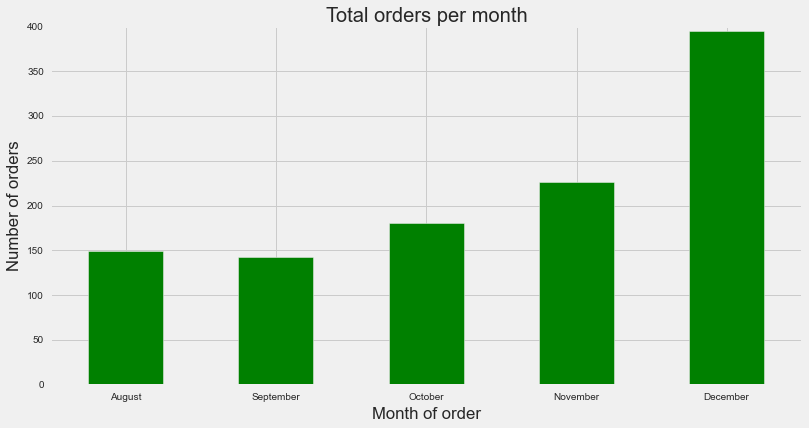

In [11]:
df.groupby('order_month')['orders'].sum().plot(kind='bar',color='g')
plt.xticks([0,1,2,3,4] ,['August', 'September', 'October', 'November','December'],rotation=0)
plt.title('Total orders per month')
plt.xlabel('Month of order')
plt.ylabel('Number of orders')
plt.savefig('totalorders.png',bbox_inches='tight')

Sales drops slightly between August and September, after which an upward trend follows with a peak in orders occuring in December. This is likely reflective of people buying and taking advantage of possible christmas and black friday deals/sales . 

Let's look at daily sales to confirm this

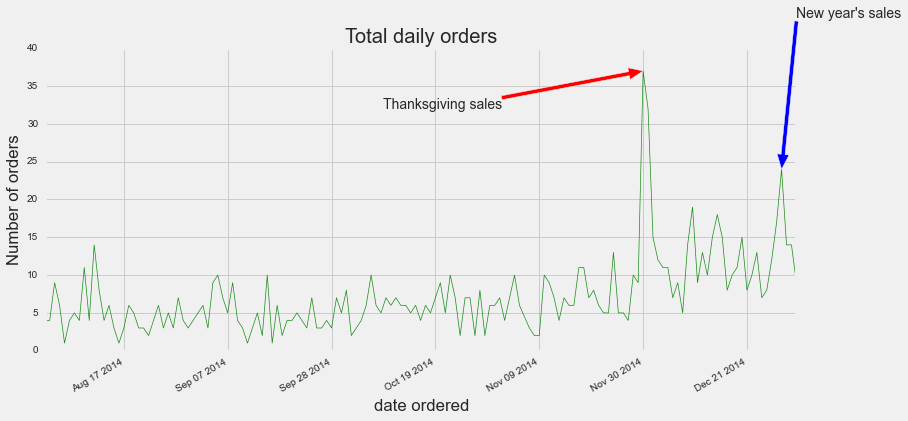

In [12]:
df.groupby('dateordered')['orders'].sum().plot(linewidth=0.7, alpha=0.9, color='g')
#ax.annotate()
plt.annotate('Thanksgiving sales', xy=(mdates.date2num(datetime.datetime(2014,11,30)), df.groupby('dateordered')['orders'].sum().max()), xytext=(0.45, 0.8),textcoords='axes fraction', arrowprops=dict(facecolor='red'))
plt.annotate("New year's sales", xy=(mdates.date2num(datetime.datetime(2014,12,28)), 24), xytext=(1.0, 1.1),textcoords='axes fraction', arrowprops=dict(facecolor='blue'))
plt.title('Total daily orders')
plt.ylabel('Number of orders')
plt.xlabel('date ordered')
plt.savefig('Dailysales.png',bbox_inches='tight')

As expected there are significant upticks at the end of November and December. Black Friday sales and New Year sales likely cause

### Returns per month

In [13]:
returned=df[df.orderstatus=='returned']

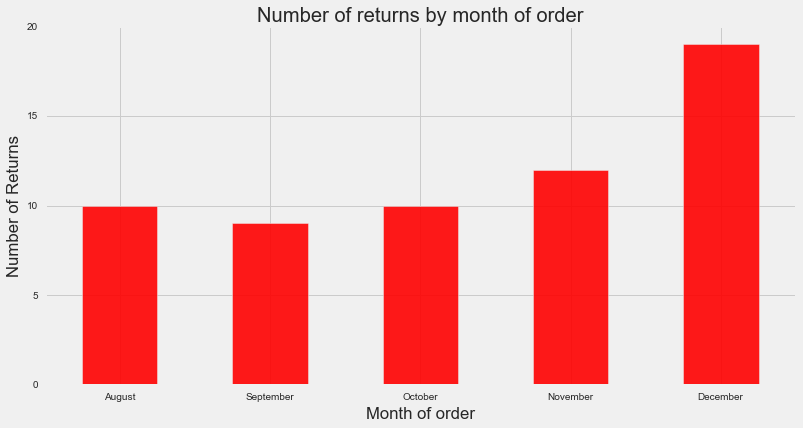

In [14]:
returned.groupby('order_month')['orders'].sum().plot(kind='bar', alpha=0.9, color='r')
plt.xticks([0,1,2,3,4] ,['August', 'September', 'October', 'November','December'],rotation=0)
plt.title('Number of returns by month of order')
plt.ylabel('Number of Returns')
plt.xlabel('Month of order')
plt.savefig('Returnsbyordermonth.png',bbox_inches='tight')

The trend mimics the trend we observed for products sold. 

## What is the monthly return rate?
The return rate is the fraction of products sold in a particular month that end up being returned

In [15]:
a=df.groupby('order_month')['orders'].agg({'total orders':np.sum}) #compute the total orders in any month

In [16]:
c=returned.groupby('order_month')['orders'].agg({'total returns':np.sum}) #compute the total number of returns 

In [17]:
data=pd.concat([a,c],axis=1)

In [18]:
data=data.reset_index()

In [19]:
data

,order_month,total orders,total returns
0,8.0,149,10
1,9.0,143,9
2,10.0,180,10
3,11.0,226,12
4,12.0,395,19


In [20]:
data['return_rate']=(data['total returns']/data['total orders'])*100

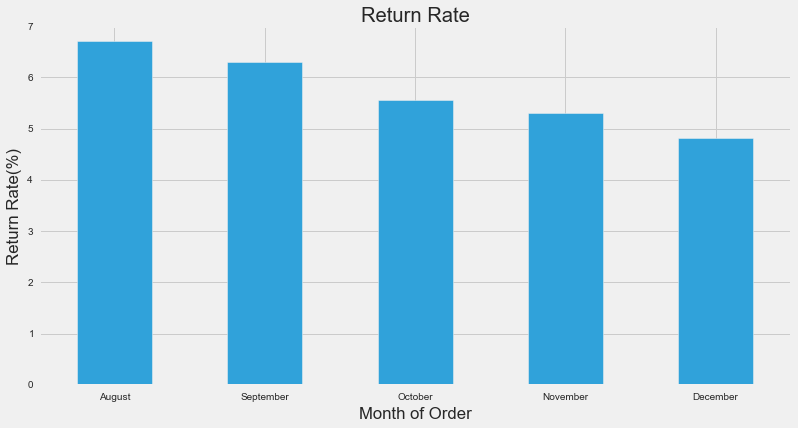

In [23]:
data.groupby('order_month')['return_rate'].sum().plot(kind='bar')
plt.xticks([0,1,2,3,4] ,['August', 'September', 'October', 'November','December'],rotation=0)
plt.ylabel('Return Rate(%)')
plt.xlabel('Month of Order')
plt.title('Return Rate')
plt.savefig('ReturnRate.png',bbox_inches='tight')

Return appears to be trending down

## Some other interesting things

Even though it seems that returns are trending down, we must keep in mind that products that are still within the 100 day purchase can still be returned.

Let's look at the number of days between returns

1. How long does it take customers to return a product? Average, median, histogram as well
2. What is the average return time in 

In [24]:
print "The average number of days it takes to return a product is " + str(round(returned.daystoreturn.mean(),2)) +" days"
print "The median number of days it takes to return a product is " + str(round(returned.daystoreturn.median(),2)) +" days"

The average number of days it takes to return a product is 40.83 days
The median number of days it takes to return a product is 28.5 days


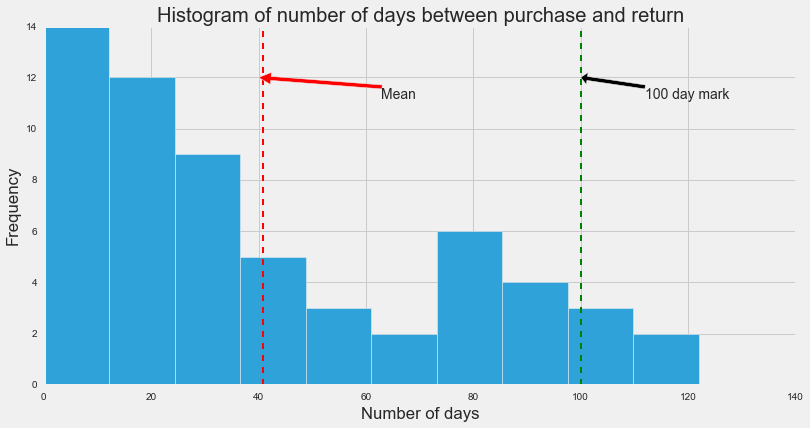

In [25]:
returned.daystoreturn.plot.hist()
plt.axvline(returned.daystoreturn.mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(100,color='g',linestyle='dashed', linewidth=2)
plt.annotate('Mean', xy=(40, 12), xytext=(0.45, 0.8),textcoords='axes fraction', arrowprops=dict(facecolor='red'))
plt.annotate('100 day mark', xy=(100, 12), xytext=(0.8, 0.8),textcoords='axes fraction', arrowprops=dict(facecolor='black'))
plt.title('Histogram of number of days between purchase and return')
plt.xlabel('Number of days')
plt.savefig('daystoreturn_hist.png',bbox_inches='tight')

The red line is the average number of days while the green is the end of the 100 day period. Surprisingly, some clients return their products after 100days. 
1. How many clients fall into this group?

In [26]:
returned[returned.daystoreturn>=100]

,dateordered,datereturned,orderstatus,orders,order_month,return_month,daystoreturn,today,lastday,days_after_order
124,2014-10-06,2015-01-20,returned,1,10.0,1.0,106.0,2015-01-28,2015-01-14,114.0
196,2014-08-11,2014-12-11,returned,1,8.0,12.0,122.0,2015-01-28,2014-11-19,170.0
204,2014-08-06,2014-11-15,returned,1,8.0,11.0,101.0,2015-01-28,2014-11-14,175.0
205,2014-08-06,2014-11-25,returned,1,8.0,11.0,111.0,2015-01-28,2014-11-14,175.0


### What portion of clients return before 40days? 

In [27]:
len(returned[returned.daystoreturn<=returned.daystoreturn.mean()])

38

In [28]:
print str(round(len(returned[returned.daystoreturn<=returned.daystoreturn.mean()])/float(len(returned))*100,2)) +"% of returns occurred within the first 40days"

63.33% of returns occurred within the first 40days


([<matplotlib.axis.XTick at 0x10c079610>,
 <a list of 5 Text xticklabel objects>)

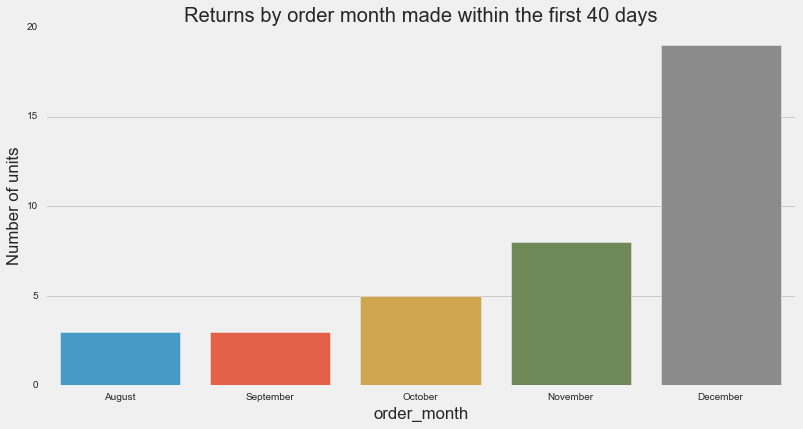

In [31]:
sns.countplot(returned[returned.daystoreturn<=40]['order_month'])
plt.title('Returns by order month made within the first 40 days')
plt.ylabel('Number of units')
plt.xticks([0,1,2,3,4] ,['August', 'September', 'October', 'November','December'],rotation=0)

## Orders marked as complete

In [32]:
complete=df[df.orderstatus=='complete']

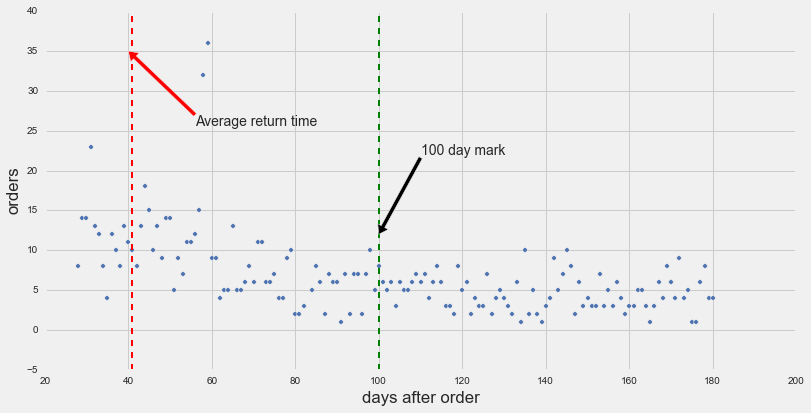

In [34]:
complete.plot(kind='scatter',x='days_after_order',y='orders')
plt.axvline(returned.daystoreturn.mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(100, color='g', linestyle='dashed', linewidth=2)
plt.annotate('Average return time', xy=(40, 35), xytext=(0.2, 0.68),textcoords='axes fraction', arrowprops=dict(facecolor='red'))
plt.annotate('100 day mark', xy=(100, 12), xytext=(0.5, 0.6),textcoords='axes fraction', arrowprops=dict(facecolor='black'))
plt.xlabel('days after order')
plt.title('')
plt.savefig('daysleftscatter.png',bbox_inches='tight')
#plt.axvline(100,color='g',linestyle='dashed', linewidth=2)

In [38]:
print len(complete[complete['days_after_order']>100]) #number of transactions older than 100 days
 

81


In [39]:
complete[complete['days_after_order']>100]['orders'].sum()  #total number of units older than 100days

375

In [40]:
len(complete[complete['days_after_order']<=41]) # number of transactions within the average return time

14

In [41]:
complete[complete['days_after_order']<=41]['orders'].sum() #total number of units within average return

160

In [42]:
len(complete[(complete['days_after_order']>40) &(complete['days_after_order']<=100) ])

59

In [43]:
(complete[(complete['days_after_order']>40) &(complete['days_after_order']<=100) ])['orders'].sum()

508